In [ ]:
!pip3 install news-please

In [2]:
import pandas as pd
import requests
import time
import newsplease
from tqdm import tqdm
import json
import os
from newsplease import NewsPlease
from urllib.parse import urlparse

### URL File from Mediacloud

In [34]:
df_urls = pd.read_csv('C:/Users/analo/OneDrive - UvA/Project/Data/Mediacloud urls/VoterID.csv') #loading url file
df_urls.head()  

,stories_id,publish_date,title,url,language,ap_syndicated,themes,media_id,media_name,media_url
0,318516682,2015-02-13 15:13:13,Republicans are pledging to win more of the bl...,http://feeds.voices.washingtonpost.com/c/34656...,en,False,NaN,2,Washington Post,http://washingtonpost.com
1,323242249,2015-03-02 17:28:43,Justices Show Skepticism on Independent Redist...,http://rss.nytimes.com/c/34625/f/642562/s/43f6...,en,False,NaN,1,New York Times,http://nytimes.com
2,323401825,2015-03-03 00:45:38,New NYC municipal ID law allows city to destro...,http://feeds.foxnews.com/~r/foxnews/politics/~...,en,False,NaN,1092,Fox News,http://www.foxnews.com/
3,324190194,2015-03-05 16:08:00,Gov. Scott Walker's miserable leadership skills,http://feeds.chicagotribune.com/~r/chicagotrib...,en,False,NaN,9,Chicago Tribune,http://www.chicagotribune.com/
4,324879421,2015-03-08 12:40:01,2nd Bridge Crossing Planned at Selma Commemora...,http://rss.nytimes.com/c/34625/f/642562/s/442a...,en,False,NaN,1,New York Times,http://nytimes.com


In [35]:
pd.DataFrame(df_urls['media_url'].value_counts()) #counting urls per news media source

,media_url
http://washingtonpost.com,593
http://www.foxnews.com/,483
http://nytimes.com,313
http://www.cnn.com/,309
http://www.nypost.com/,98
http://www.chicagotribune.com/,49


In [ ]:
# checking if NewsPlease works with one url
article = NewsPlease.from_url('http://rss.cnn.com/~r/rss/cnn_latest/~3/23KEGtvT-bo/index.html')
print(article.title)
print(article.maintext)

### Retrieving articles from URLs

We load the txt file with a list of urls and retrieve stories. 

In [3]:
name = 'urls.txt'
basepath = 'C:/Users/analo/OneDrive - UvA/Project/Data/'
articles = NewsPlease.from_file(basepath + name)

In [4]:
# Damians beautiful code!
with open("output.json", mode = 'w') as f:
    for v in articles.values():
        f.write(json.dumps(v.get_serializable_dict()))
        f.write("\n")

In [5]:
data = pd.read_json('output.json', lines=True) # convert to dataframe

In [ ]:
data['maintext'][10]

In [5]:
# create list of all urls from txt file
with open('C:/Users/analo/OneDrive - UvA/Project/Data/Mediacloud urls/VoterID.txt') as f:
    urls = [e.strip() for e in f.readlines()]


In [8]:
len(urls) # check amount of urls

1845

In [ ]:
# retrieve html pages from list of urls 
allpages = {}
for url in tqdm(urls):
    try:
        r = requests.get(url)
        if r.status_code==200:
            allpages[url] = r.text #only read the html text if page exists
        else:
            print(f'Downloading {url} returned status code {r.status_code}')
    except:
        print(f'some error occurred when downloading {url}')
with open('TMP.json',  mode='w') as f:
    json.dump( allpages, f)

In [7]:
len(allpages) # check how many pages were retrieved


1682

In [9]:
allpages_parsed = {}
for k, v in tqdm(allpages.items()):
    allpages_parsed[k] = NewsPlease.from_html(v) # use NewsPlease here to download the stories from the html info retrieved

 13%|█▎        | 217/1682 [01:21<10:06,  2.42it/s]C:\Users\analo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname CST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
100%|██████████| 1682/1682 [14:14<00:00,  1.97it/s]


In [ ]:
# checking whether source domain is there
for k, v in allpages_parsed.items():
    print(v.source_domain)

In [10]:
with open("output.json", mode = 'w') as f: #write json file with media data
    for k, v in allpages_parsed.items():
        mydict = v.get_serializable_dict()
        mydict['url'] = k
        f.write(json.dumps(mydict))
        f.write("\n")

In [ ]:
data = pd.read_json('output.json', lines=True) # convert to dataframe

In [19]:
# Find source from url link
def urltosource(link):
    source = urlparse(link).netloc
    return source

source = urltosource(data['url'][1]) #checking if it works
source

'www.washingtonpost.com'

In [20]:
# Create a source column from urls
data['source'] = data['url'].apply(urltosource)
data.head()

,authors,date_download,date_modify,date_publish,description,filename,image_url,language,localpath,maintext,source_domain,text,title,title_page,title_rss,url,source
0,"[Tampa Tim, Rudy Nyc, The, Compassionate, Gop ...",None,None,2014-04-30 00:00:00,(CNN) -- In an exclusive interview with CNN Ch...,.json,http://i2.cdn.turner.com/cnn/dam/assets/140430...,en,NaN,8 years ago\n(CNN) - In an exclusive interview...,NaN,NaN,Rep. Thompson doubles down on racial remarks i...,NaN,NaN,http://politicalticker.blogs.cnn.com/2014/04/3...,politicalticker.blogs.cnn.com
1,[],None,None,2014-06-04 12:35:55,A look at the likely limited spread of Seattle...,.json,https://www.washingtonpost.com/resizer/2CjPNwq...,en,NaN,Wonkbook’s Chart of the Day: The decreasing va...,NaN,NaN,Wonkbook: Will Seattle’s $15 minimum wage expe...,NaN,NaN,http://www.washingtonpost.com/blogs/wonkblog/w...,www.washingtonpost.com
2,[],None,None,2013-07-05 12:59:09,Arguments over legislative tactics obscure que...,.json,https://www.washingtonpost.com/resizer/2CjPNwq...,en,NaN,Candidate McCrory tried to occupy a middle gro...,NaN,NaN,Abortion restrictions in North Carolina Senate...,NaN,NaN,http://www.washingtonpost.com/blogs/she-the-pe...,www.washingtonpost.com
3,[Tom Lobianco],None,None,2015-08-06 16:50:30,An appeals court ruled late Wednesday that a k...,.json,https://cdn.cnn.com/cnnnext/dam/assets/1112290...,en,NaN,Story highlights An appeals court ruled that a...,NaN,NaN,Texas voter ID law: Appeals court strikes down...,NaN,NaN,http://rss.cnn.com/~r/rss/cnn_latest/~3/LB85Py...,rss.cnn.com
4,[],None,None,2017-11-18 14:37:43,Gov. Bruce Rauner seems to admire Gov. Scott W...,.json,https://www.chicagotribune.com/resizer/Dq9daIb...,en,NaN,Gov. Mark Dayton of Minnesota took an opposite...,NaN,NaN,Will Illinois be the next Wisconsin?,NaN,NaN,http://feeds.chicagotribune.com/~r/chicagotrib...,feeds.chicagotribune.com


In [24]:
# save data to csv file
data.to_csv('C:/Users/analo/OneDrive - UvA/Project/Data/Mediacloud urls/Data.csv', index = False)

## Descriptive stats

In [ ]:
# load categorised data by media ideological affiliation
df = pd.read_csv('C:/Users/analo/OneDrive - UvA/Project/Data/Mediacloud urls/Data_modified.csv')
df.head()  

In [4]:
domain = df['type2'].value_counts()
pd.DataFrame(domain)

,type2
liberal,773
conservative,570
moderate,331


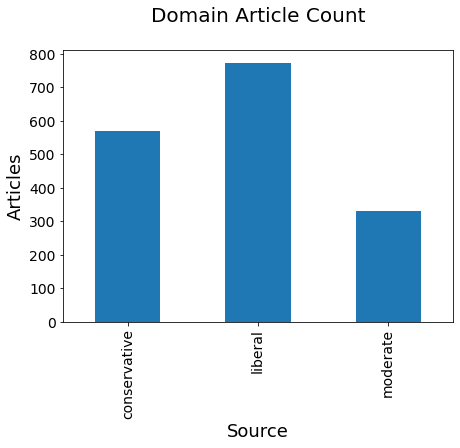

In [5]:
ax = domain.sort_index().plot(kind='bar', fontsize=14, figsize=(7,5)) # Counting articles per news source
ax.set_title('Domain Article Count\n', fontsize=20)
ax.set_xlabel('Source', fontsize=18)
ax.set_ylabel('Articles', fontsize=18);

Fetching stories from a txt file containing all URLs (each line containing a single URL)

In [43]:
# clean dataframe a bit
df = data.drop(columns=['date_modify', 'date_download', 'filename', 'image_url', 'language', 'localpath', 'text', 'title_page', 'title_rss', 'authors', 'url','description']) # Remove columns

In [48]:
df["Date"] = pd.to_datetime(df["date_publish"])
df.head()

,date_publish,maintext,source_domain,title,Date
0,2020-09-03 14:01:50,NEW You can now listen to Fox News articles!\n...,www.foxnews.com,Arnold Schwarzenegger offers to pay for reopen...,2020-09-03 14:01:50
1,2020-07-23 06:00:01,"With the death of Congressman John Lewis, Amer...",www.newsweek.com,"MLK III: In the Name of John Lewis, Let Us Res...",2020-07-23 06:00:01
2,2020-09-28 18:33:10,NEW You can now listen to Fox News articles!\n...,www.foxnews.com,Wisconsin voters win protection against strict...,2020-09-28 18:33:10
3,2020-02-13 21:31:08,The decree will be enforced by a federal court...,www.nytimes.com,North Dakota Tribes Score Key Voting Rights Vi...,2020-02-13 21:31:08
4,2020-11-05 03:03:39,With concerns mounting over how the country ca...,www.nytimes.com,Trump Is Pushing a False Argument on Vote-by-M...,2020-11-05 03:03:39
